# CSCI 381/780 (Fall 2023) - Project 2

**Due Date: Friday, October 27 by 4 PM**

## Description
In this project you will construct machine learning models on two different real-world datasets using unsupervised learning and regression.

## Instructions
1. In this project you will write code to construct machine learning models and write responses to questions concerning the performance of said models. Please complete all sections below, adding new *Code* or *Markdown* cells as appropriate to answer the questions.
2. There are many Scikit-learn functions that leverage randomness to generate results. For these functions, a pseudorandom generator can be initialized using a seed value by passing the parameter `random_state=XXX`, where `XXX` is some number between 1 and 2^31-1. For each of these functions, **you will utilize your CUNY ID number** to initialize the function. Functions include:
- `ShuffleSplit`
- `KFold`
- `KMeans`
- `GridSearchCV`
- `Lasso`, `Ridge`, `ElasticNet`
- `MLPRegressor`
3. You will **work independently** on the project. Please make use of the *Python Data Science Reference Materials* posted on Blackboard, or **come to office hours should you need further assistance**.
4. You will submit a single Jupyter notebook containing all code and written responses via Blackboard by the due date listed above.

## Grading

### Running Code
Your Jupyter notebook must be able to run from start to finish **without error**. Please turn any cell that contains scratch work or other non-executable items to *Raw*. **Notebooks that cannot run to completion will receive a grade of 0**.


### Rubric

|**Part**|1.1|1.2|2.1|2.2|2.3|2.4|2.5|2.6|2.7|**Total**|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|**%**|10|25|15|5|5|10|10|10|10|100|

# Part 1: Clustering

In this part of the project, you will be using data collected by the US Geological Survey and the US Forest Service. The data describes various cartographic and geologic features related to forest cover in US wilderness areas, with each sample representing a 30 x 30 meter cell.

The **goal** will be to *identify clusters* that represent forest cover types, and using these clusters *extract relationships* between forest covers and the provided cartographic/geologic features.

In [1]:
cover_column_names=["Elevation","Aspect","Slope",
              "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
              "Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon",
              "Hillshade_3pm","Horizontal_Distance_To_Fire_Points"]
wilderness_cols =["Wilderness_"+str(i) for i in range(4)]
soil_col =["Soil_"+str(i) for i in range(40)]
cover_columns_names = cover_column_names + wilderness_cols + soil_col

## 1.1 Load Data
Set the variable `COVER_FILE` to the **full path** to the forest cover dataset (**forest_cover_dataset.csv**) on your system. Load the file into a dataframe (you may initialize the column names using the header list `cover_column_names`), then:
1. Determine the number and types of features.
2. Perform a **ShuffleSplit** of the data into training/validation/test sets, 60%/20%/20%.
3. **Center** the training/validation/test splits (fit on the training set, then transform the validation/test sets).

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit, train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import time
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.pipeline import make_pipeline



#I import all modules used in the project at once in the cell, in order to prevent import module repetitively  

# This project has been executed several times, so the data in the answers section may be slightly different

In [3]:
COVER_FILE = 'forest_cover_dataset.csv'  # place same directory with this file

# Load the data with the provided column names
df = pd.read_csv(COVER_FILE, names=cover_column_names)

# Determine the number and types of features
num_features = df.shape[1]
feature_types = df.dtypes
print("Number of features:", num_features)
print("Types of features:\n", feature_types)

# ShuffleSplit the data
splitter = ShuffleSplit(n_splits=1, test_size=0.4, random_state=23655842)
for train_index, temp_index in splitter.split(df):
    df_train = df.iloc[train_index]
    df_temp = df.iloc[temp_index]

# Perform a ShuffleSplit of the data into training/validation/test sets, 60%/20%/20%.
df_valid, df_test = df_temp.iloc[:len(df_temp)//2], df_temp.iloc[len(df_temp)//2:]

# Center the datasets
scaler = StandardScaler().fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train), columns=cover_column_names)
df_valid = pd.DataFrame(scaler.transform(df_valid), columns=cover_column_names)
df_test = pd.DataFrame(scaler.transform(df_test), columns=cover_column_names)

# Replace '?' with nan and drop nan values, prepare for part 2
df_train.replace('?', np.nan, inplace=True)
df_train.dropna(inplace=True)

Number of features: 10
Types of features:
 Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
dtype: object


In [4]:
df.head()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
2825,265,17,319,108,2298,174,245,209,342,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2719,198,34,134,76,2352,187,245,167,693,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3146,152,14,212,41,940,237,239,130,2007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2882,18,18,95,-3,485,203,199,128,342,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2912,349,17,283,57,2729,187,210,160,2201,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## 1.2 $k$-Means Clustering

1. Cluster the *training* dataset using ```KMeans``` from Scikit-learn using the values for $k$ below. You can utilize the default implementation in Scikit-learn, which is $k$-means$++$. Construct models for each value of $k$ specified in the ``k_values`` array below.
2. Apply the trained models to the validation dataset.
3. Compute the **mean** inertia for each value of $k$ on the training and validation datasets. For the training data, you can extract the *total* (**unnormalized**) inertia from the trained models via their respective ```inertia_```. For the validation models, you can utilize the function ```total_inertia``` provided below.
4. Plot the mean inertias for all values of $k$ and for both the training and validation sets on a single plot. Based on the elbow method, which value of $k$ should be chosen so that the model will generalize to new data?
5. The *Silhouette Coefficient* is another cluster performance metric that combines intra-cluster distance with inter-cluster distances from clusters in close proximity to each other. Utilize Scikit-learn's ```silhouette_score``` function [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) to compute the silhouette coefficient for all values of $k$ on the *validation* set. Plot these values and determine via the elbow method which value of $k$ should be chosen. How does this value compare to the one chosen using mean inertia?
6. Using whichever value of $k$ you think is the best based on steps 4) and 5), create a plot for each feature that contains [boxplots](https://matplotlib.org/stable/gallery/statistics/boxplot_demo.html#sphx-glr-gallery-statistics-boxplot-demo-py) of that feature for each cluster. Based upon these plots, determine which features you think are meaningful in discriminating between the clusters, as well as any other trends you observe.

### Please Read!
You may benefit from parallelizing the creation of the $k$-means models by using the Python package ```joblib```. I've included a code template below that you can customize. For additional details, please refer to [joblib's documentation](https://joblib.readthedocs.io/en/latest/parallel.html).

In [5]:
df = df.reset_index(drop=True)

def cluster_data(k, dataset):
    kmeans = KMeans(n_clusters=k, random_state=23655842).fit(dataset)
    return kmeans

def total_inertia(dataset, cluster_centers, labels):
    distances = np.zeros(dataset.shape[0])

    for i, label in enumerate(labels):
        center = cluster_centers[label]
        distances[i] = np.linalg.norm(dataset.iloc[i] - center)

    return sum(distances**2)

k_values = list(range(2, 11))  # for example, if you're trying clusters from 2 to 10

# Using parallel backend to cluster data
with parallel_backend("loky", inner_max_num_threads=2):
    models = Parallel(n_jobs=4)(delayed(cluster_data)(k, df) for k in k_values)

training_inertias = [model.inertia_ for model in models]
validation_inertias = [total_inertia(df_valid, model.cluster_centers_, model.predict(df_valid)) for model in models]

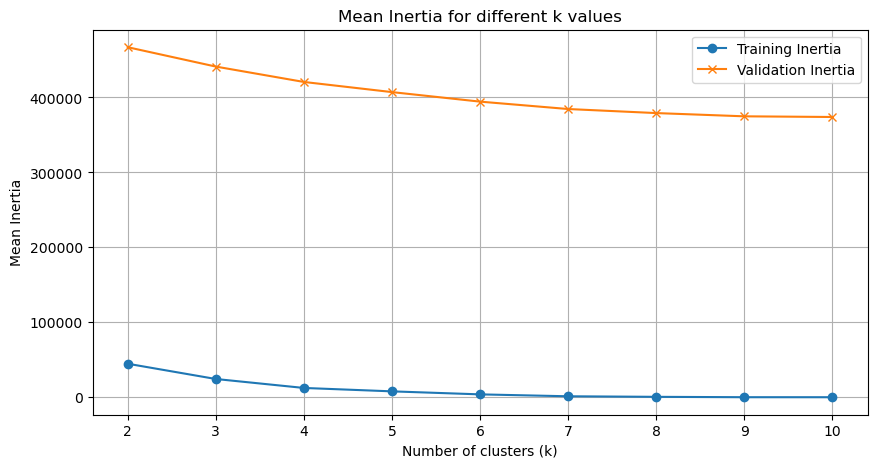

In [6]:

plt.figure(figsize=(10, 5))
plt.plot(k_values, training_inertias, marker='o', label="Training Inertia")
plt.plot(k_values, validation_inertias, marker='x', label="Validation Inertia")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Mean Inertia')
plt.title('Mean Inertia for different k values')
plt.legend()
plt.grid(True)
plt.show()

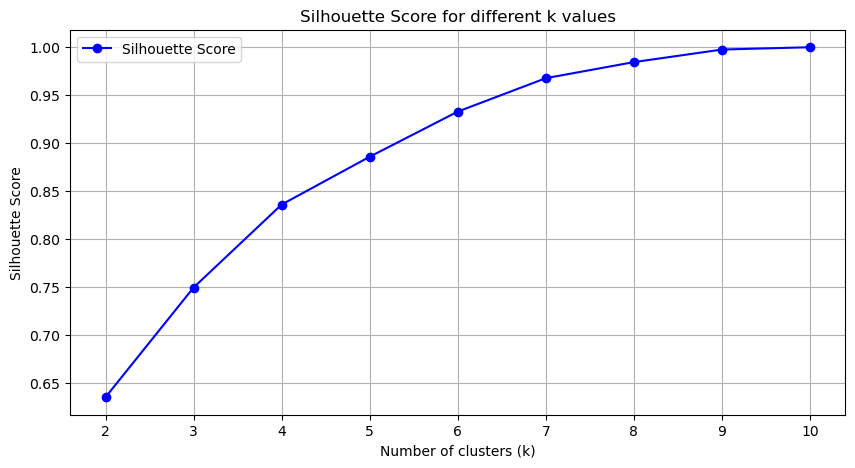

In [7]:

silhouette_scores = [silhouette_score(df_valid, model.predict(df_valid)) for model in models]

plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='b', label="Silhouette Score")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different k values')
plt.legend()
plt.grid(True)
plt.show()

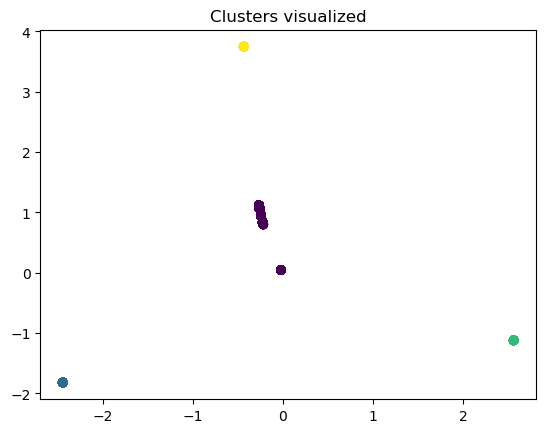

168150
168150
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0          0       0      1                                 0   
1          0       0      0                                 0   
2          0       0      0                                 0   
3          1       0      0                                 0   
4          0       0      0                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                                0   
1                               0                                0   
2                               0                                0   
3                               0                                0   
4                               0                                0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0              0               0              0   
1              0               0              0   
2              0     

In [8]:

'''
#replace ? with nan
df_train.replace('?', np.nan, inplace=True)
df_train.dropna(inplace=True)
'''
#with dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_train)

kmeans = KMeans(n_clusters=4, n_init='auto', random_state=23655842)  # Define kmeans object here
kmeans.fit(reduced_data)
labels = kmeans.labels_
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.title("Clusters visualized")
plt.show()

print(len(labels))
print(len(df_train))
print(df.head())



In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_train)
print(pca.explained_variance_ratio_)


[0.12160961 0.11775151]


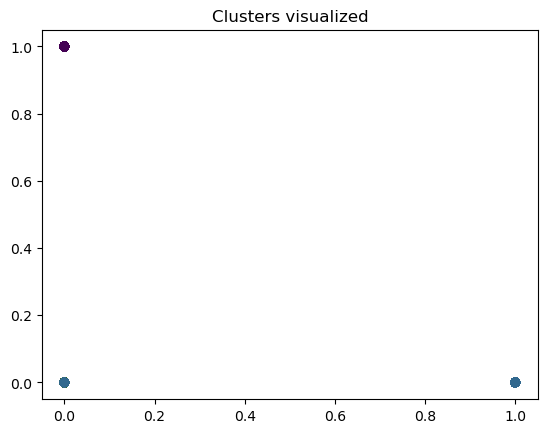

In [10]:

# Initialize KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, n_init='auto',random_state=23655842)

kmeans.fit(df)

# Get cluster assignments for each data point
labels = kmeans.labels_

plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=labels, cmap='viridis')
plt.title("Clusters visualized")
plt.show()

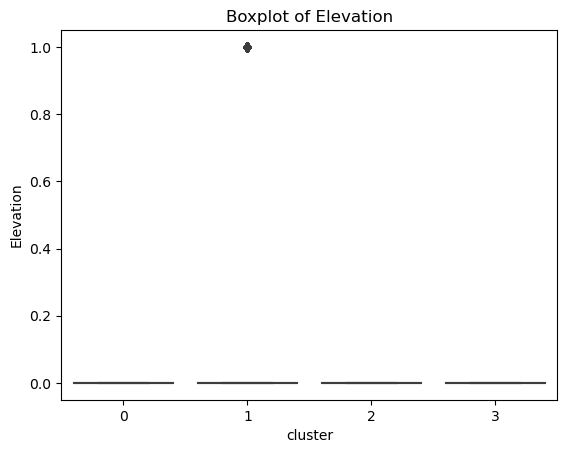

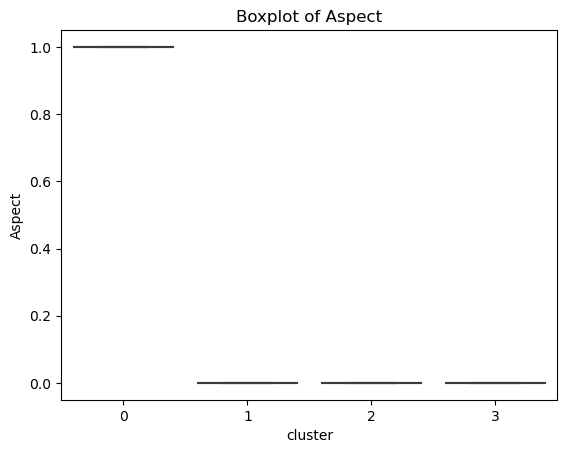

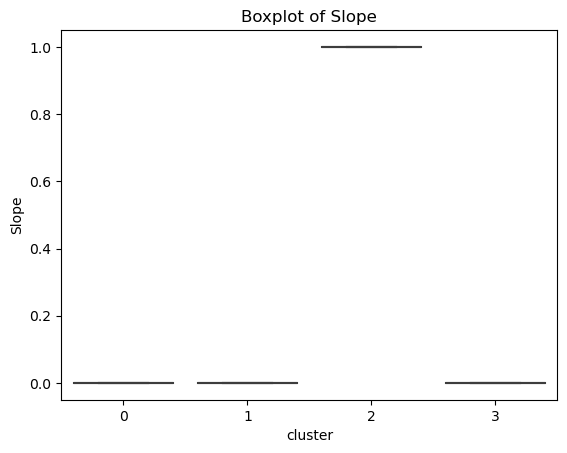

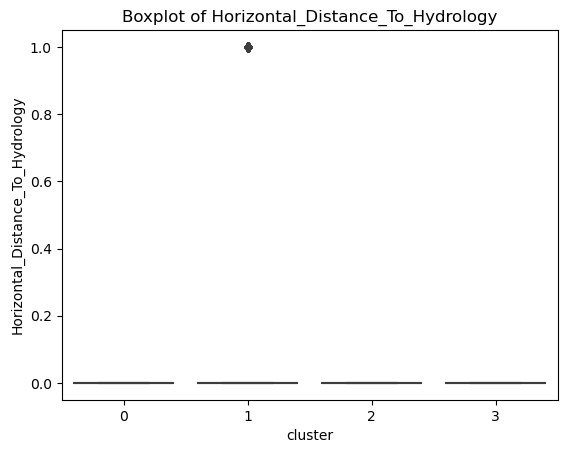

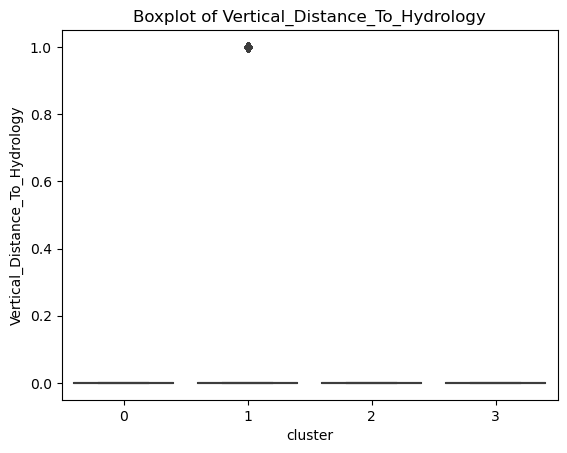

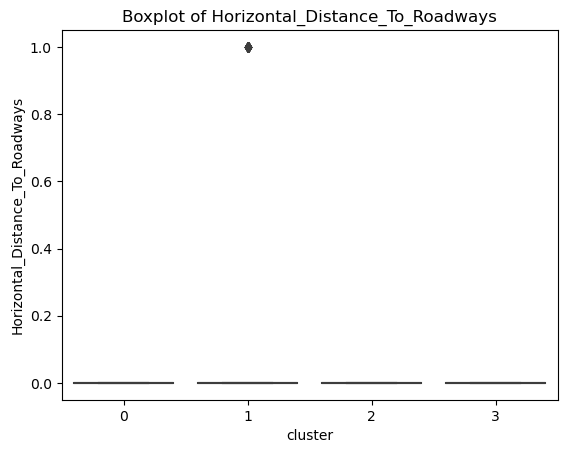

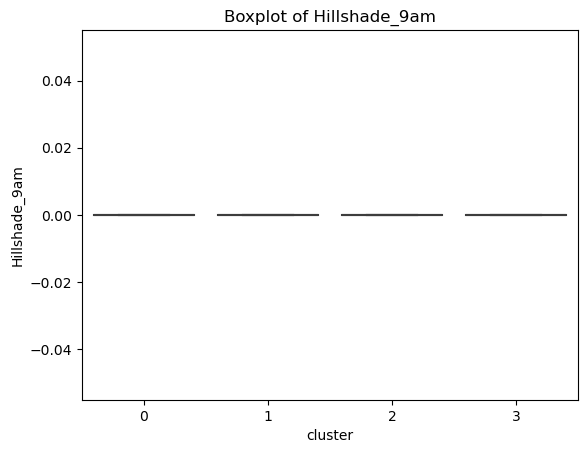

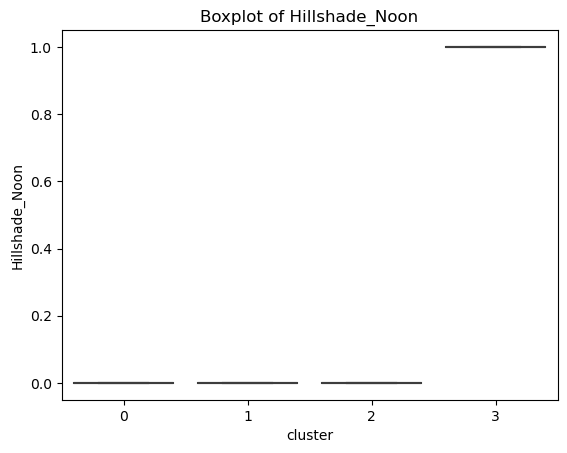

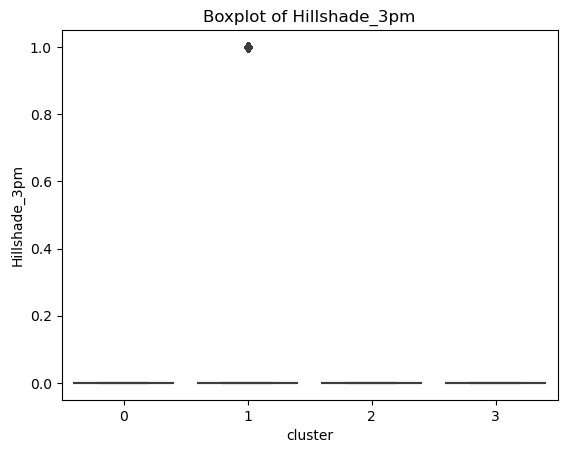

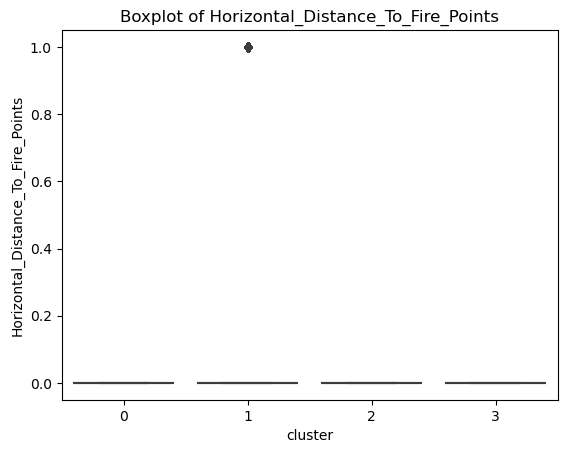

In [11]:

df['cluster'] = labels
for col in df.columns[:-1]:
    sns.boxplot(x='cluster', y=col, data=df)
    plt.title(f"Boxplot of {col}")
    plt.show()


# Part 2: Regression

In this part of the project, you will be utilizing a US database of crime and law enforcement statistics broken down by US Census communities. The **goal** will be to create *regression models* that predict *per capita violent crimes* (the response variable `ViolentCrimesPerPop`) for a given community based on these inputs.

In [12]:
crime_column_names= ['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize',
                 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
                 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf',
                 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap',
                 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov',
                 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu',
                 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr',
                 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par',
                 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent',
                 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8',
                 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup',
                 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous',
                 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded',
                 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal',
                 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc',
                 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85',
                 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
                 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic',
                 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp',
                 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked',
                 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
                 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop']

## 2.1 Load Data
Set the variable `CRIME_FILE` to the **full path** to the forest cover dataset (**crime.csv**) on your system. Load the file into a dataframe (you may initialize the column names using the header list `crime_column_names`), then:
1. Determine the number and types of features.
2. Perform a **ShuffleSplit** of the data into training/validation/test sets, 60%/20%/20%.
3. Split the **non-test data** (*training* + *validation* data) into **5 folds** for cross-validation purposes.
4. Perform any necessary preprocessing on dataset. This may include:
  * determining if any features should be dropped;
  * handling missing data, through imputation and/or complete case analysis. If you **perform imputation on numerical values**, please use **median** imputation.

**Please note!** The Scikit-learn function `SimpleImputer` does not work as expected when the feature to impute is numerical but the missing values are not. One way to solve this is to first replace the missing values with NaN values (e.g., `np.nan`) using the Pandas Dataframe method `replace` [(documentation)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html).

In [13]:
#peformance metric functions
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

#A list of keys for the dictionary returned by p1_metrics
metric_keys = ['mse','mae','r2']

def p2_metrics(y_true,y_pred,negation=False):
    if negation:
        sign = -1
    else:
        sign = 1
    return {
        'mse': sign*mean_squared_error(y_true,y_pred),
        'mae': sign*mean_absolute_error(y_true,y_pred),
        'r2': sign*r2_score(y_true,y_pred)}

#This wrapper can be used to return multiple performance metrics during cross-validation
def p2_metrics_scorer(clf,X,y_true):
    y_pred=clf.predict(X)
    return p2_metrics(y_true,y_pred,negation=True)




In [14]:

# 1. Load Data
CRIME_FILE = 'crime.csv'
df = pd.read_csv(CRIME_FILE, names=crime_column_names, header=None)

# 2. Data Summary
print(f"Total Features: {df.shape[1] - 1}")
print(df.info())

# 3. Data Splitting using ShuffleSplit
ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=23655842)
for train_index, test_index in ss.split(df):
    train_temp, test_data = df.iloc[train_index], df.iloc[test_index]

# Further split the train_temp into train_data and val_data
train_data, val_data = train_test_split(train_temp, test_size=0.25, random_state=23655842) # 0.25 x 0.8 = 0.2

# 4. Preprocessing

'''
#replace ? with nan
df_train.replace('?', np.nan, inplace=True)
df_train.dropna(inplace=True)
'''

##https://stackoverflow.com/questions/40095712/when-to-applypd-to-numeric-and-when-to-astypenp-float64-in-python#:~:text=In%20%5B99%5D%3A%20df%5B%27b%27%5D%20%3D%20pd.to_numeric(df%5B%27b%27%5D%2C%20errors%3D%27coerce%27)
# Replace non-numeric missing values in numeric columns with NaN
for col in df.columns:
    if df[col].dtype in ['float64', 'int64'] and df[col].isnull().any():
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Median Imputation for Numerical Columns
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

if train_data.isnull().sum().sum() > 0:
    print("Missing values in train_data")
if val_data.isnull().sum().sum() > 0:
    print("Missing values in val_data")
print('target ViolentCrimesPerPop in the train_data')
print('ViolentCrimesPerPop' in train_data.columns)
print('target ViolentCrimesPerPop in the val_data')
print('ViolentCrimesPerPop' in val_data.columns)
print('target ViolentCrimesPerPop in the test_data')
print('ViolentCrimesPerPop' in test_data.columns)


Total Features: 127
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 128 entries, state to ViolentCrimesPerPop
dtypes: float64(100), int64(2), object(26)
memory usage: 1.9+ MB
None
target ViolentCrimesPerPop in the train_data
True
target ViolentCrimesPerPop in the val_data
True
target ViolentCrimesPerPop in the test_data
True


In [15]:
print(train_data.dtypes)


state                    int64
county                  object
community               object
communityname           object
fold                     int64
                        ...   
LemasPctPolicOnPatr     object
LemasGangUnitDeploy     object
LemasPctOfficDrugUn    float64
PolicBudgPerPop         object
ViolentCrimesPerPop    float64
Length: 128, dtype: object


In [16]:
# Drop non-numeric columns from train_data
non_numeric_cols_train = train_data.select_dtypes(exclude=['float64', 'int64']).columns
train_data = train_data.drop(columns=non_numeric_cols_train)

# Drop non-numeric columns from val_data
non_numeric_cols_val = val_data.select_dtypes(exclude=['float64', 'int64']).columns
val_data = val_data.drop(columns=non_numeric_cols_val)

# Drop non-numeric columns from test_data
non_numeric_cols_test = test_data.select_dtypes(exclude=['float64', 'int64']).columns
test_data = test_data.drop(columns=non_numeric_cols_test)

# Check data types again
print('------------ train_data ---------------- ')
print(train_data.dtypes)
print('------------ test_data ---------------- ')
print(test_data.dtypes)


------------ train_data ---------------- 
state                    int64
fold                     int64
population             float64
householdsize          float64
racepctblack           float64
                        ...   
LandArea               float64
PopDens                float64
PctUsePubTrans         float64
LemasPctOfficDrugUn    float64
ViolentCrimesPerPop    float64
Length: 102, dtype: object
------------ test_data ---------------- 
state                    int64
fold                     int64
population             float64
householdsize          float64
racepctblack           float64
                        ...   
LandArea               float64
PopDens                float64
PctUsePubTrans         float64
LemasPctOfficDrugUn    float64
ViolentCrimesPerPop    float64
Length: 102, dtype: object


In [17]:
train_data.head()


,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
1004,37,6,0.20,0.33,0.89,0.26,0.12,0.02,0.49,0.65,...,0.11,0.62,0.33,0.43,0.35,0.20,0.16,0.17,0.00,0.48
1514,10,8,0.03,0.51,0.60,0.47,0.12,0.05,0.64,0.69,...,0.11,0.34,0.34,0.46,0.19,0.06,0.11,0.03,0.00,0.37
920,12,5,0.00,0.15,0.30,0.75,0.04,0.07,0.17,0.26,...,0.20,0.15,0.48,0.53,0.43,0.01,0.23,0.00,0.00,0.45
1477,6,8,0.21,0.94,0.10,0.37,0.53,1.00,0.52,0.62,...,0.94,0.41,0.47,0.69,0.67,0.07,0.49,0.06,0.43,0.41
66,37,1,0.07,0.42,0.48,0.61,0.04,0.01,0.43,0.48,...,0.03,0.77,0.59,0.80,0.76,0.09,0.15,0.05,0.00,0.61


In [18]:
test_data.head()

,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
1786,9,9,0.03,0.33,0.02,0.97,0.05,0.03,0.25,0.30,...,0.36,0.69,0.88,0.95,0.88,0.03,0.17,0.21,0.0,0.09
651,6,4,0.04,0.46,0.02,0.80,0.38,0.29,0.38,0.51,...,0.37,0.47,0.49,0.60,0.72,0.03,0.27,0.04,0.0,0.15
10,6,1,0.13,0.71,0.15,0.07,1.00,0.41,0.40,0.52,...,1.00,0.35,0.53,0.39,0.62,0.02,1.00,1.00,0.0,0.24
1752,34,9,0.02,0.48,0.23,0.76,0.18,0.06,0.28,0.34,...,0.39,0.53,0.76,0.65,0.60,0.01,0.47,0.98,0.0,0.19
1121,25,6,0.03,0.38,0.04,0.93,0.14,0.03,0.25,0.44,...,0.20,0.71,0.71,0.69,0.70,0.04,0.17,0.40,0.0,0.08


## 2.2 Linear Regression

1. Construct a linear model using Scikit-learn's `LinearRegression` method with default parameters.
2. Report the following performance metrics on the **training and validation sets**:
    *Mean Squared Error*, *Mean Absolute Error*, and the *Coefficient of Determination ($r^2$)*.
    
    You can use the function `p2_metrics` for this purpose. Is this model underfitting the data? Is so, why?
3. Report the weights (coefficients) of the linear model and their associated features in ascending order.

    Larger weights indicate that their corresponding features have more influence in the model. Moreover, negative weights correspond to variables having negative correlation with the response variable, and vice versa.
    
    Using this interpretation, describe the most significant features and their correlation.

Anwser:

Training Metrics - MSE: 0.0081280403069442, MAE: 0.07190556033819265, R^2: 0.8684126944004916

Validation Metrics - MSE: 0.04313961311904458, MAE: 0.16474800236296502, R^2: 0.19397898171961792

base on output the model is overfitting  the data, model perfom poorly on unseen data with R^2 metrics

(1st element in sorted arr)Most Significant Negative Features: perCapInc
higher income lower crime rate

([-1] element in sorted arr)Most Significant Positive Features:TotalPctDiv
divorced people have higher crime rate

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def prepare_data(train_data, val_data, test_data):
    # Drop the target column and separate the target variable
    train_target = train_data['ViolentCrimesPerPop']
    val_target = val_data['ViolentCrimesPerPop']
    test_target = test_data['ViolentCrimesPerPop']

    train_data = train_data.drop(columns=['ViolentCrimesPerPop'])
    val_data = val_data.drop(columns=['ViolentCrimesPerPop'])
    test_data = test_data.drop(columns=['ViolentCrimesPerPop'])
    
    return train_data, val_data, test_data, train_target, val_target, test_target

# Then, you can call this function before part 2.7:
train_data, val_data, test_data, train_target, val_target, test_target = prepare_data(train_data, val_data, test_data)


lr = LinearRegression()
lr.fit(train_data, train_target)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions for training and validation data
train_preds = lr.predict(train_data)
val_preds = lr.predict(val_data)

# Metrics for training data
mse_train = mean_squared_error(train_target, train_preds)
mae_train = mean_absolute_error(train_target, train_preds)
r2_train = r2_score(train_target, train_preds)

# Metrics for validation data
mse_val = mean_squared_error(val_target, val_preds)
mae_val = mean_absolute_error(val_target, val_preds)
r2_val = r2_score(val_target, val_preds)

print(f"Training Metrics - MSE: {mse_train}, MAE: {mae_train}, R^2: {r2_train}")
print(f"Validation Metrics - MSE: {mse_val}, MAE: {mae_val}, R^2: {r2_val}")

# Extract coefficients and feature names
coefficients = lr.coef_
features = train_data.columns

# Pair features with their coefficients and sort in ascending order
feature_weights = sorted(list(zip(features, coefficients)), key=lambda x: x[1])

# Print features and their weights
for feature, weight in feature_weights:
    print(f"Feature: {feature}, Weight: {weight}")

# Describe the most significant features
top_features = feature_weights[:5] + feature_weights[-5:]
print("\nThe most significant features are:")
for feature, weight in top_features:
    correlation = "negative" if weight < 0 else "positive"
    print(f"- {feature} has a {correlation} correlation with the response variable.")


Training Metrics - MSE: 0.014617055198372003, MAE: 0.08511456917576256, R^2: 0.7144883988571156
Validation Metrics - MSE: 0.0235501668942573, MAE: 0.1093305902100945, R^2: 0.6055991100049347
Feature: whitePerCap, Weight: -0.6870221277428831
Feature: PctLargHouseOccup, Weight: -0.42037691970141733
Feature: PctKids2Par, Weight: -0.41598586583582564
Feature: OwnOccLowQuart, Weight: -0.4097595098306076
Feature: PersPerOwnOccHous, Weight: -0.3596139006258872
Feature: agePct16t24, Weight: -0.352063253628583
Feature: PersPerFam, Weight: -0.3156807935560227
Feature: PctImmigRec5, Weight: -0.21855546760031658
Feature: PersPerRentOccHous, Weight: -0.2049094057735577
Feature: RentLowQ, Weight: -0.20032955618091042
Feature: PctNotSpeakEnglWell, Weight: -0.1949522370526279
Feature: FemalePctDiv, Weight: -0.19036953386964828
Feature: PctPersOwnOccup, Weight: -0.1755041442032756
Feature: pctWInvInc, Weight: -0.16079913451508435
Feature: PctRecentImmig, Weight: -0.1594751640317874
Feature: population,

## 2.3 Linear Regression and PCA

1. Perform principal component analysis on the **training data**. You may use Scikit-learn's `PCA` function for this, which **automatically centers** the data prior to PCA. Using PCA, *choose the number of components* for which the total explained variance is $\ge 99\%$, and report this.
2. After determining the correct number of components, apply the PCA transformation to the **validation** and **test** sets.
3. Create another model via `LinearRegression` but using the data transformed by PCA
Construct a linear model using Scikit-learn's `LinearRegression` method with default parameters.
4. Report the same performance metrics as in 2.2 on the **validation set**. How does the model's performance compare to that of the model in 2.2?

Answer:

Validation Metrics After PCA:
MSE: 0.0320, MAE: 0.1353, R^2: 0.4026
With PCA, the model's performance is higher than model without PCA

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Apply PCA on the training data
pca = PCA()
X_train_pca = pca.fit_transform(train_data)

# Determine number of components for which total explained variance is >= 99%
explained_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_var >= 0.99) + 1
print(f"Number of components for which total explained variance is >= 99%: {n_components}")

# Apply the PCA transformation on validation and test sets using the determined number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(train_data)
X_val_pca = pca.transform(val_data)


# 2. Construct a Linear Regression model using the PCA transformed data
model_pca = LinearRegression()
model_pca.fit(X_train_pca, train_target)

# Predict using the PCA transformed validation set
val_predictions_pca = model_pca.predict(X_val_pca)

# Compute the performance metrics
val_mse_pca = mean_squared_error(val_target, val_predictions_pca)
val_mae_pca = mean_absolute_error(val_target, val_predictions_pca)
val_r2_pca = r2_score(val_target, val_predictions_pca)

print("\nValidation Metrics After PCA:")
print(f"MSE: {val_mse_pca:.4f}, MAE: {val_mae_pca:.4f}, R^2: {val_r2_pca:.4f}")



Number of components for which total explained variance is >= 99%: 3

Validation Metrics After PCA:
MSE: 0.0371, MAE: 0.1440, R^2: 0.3782


## 2.4 Regularized Regression

### 2.4.1. LASSO

Utilizing *cross-validation* you will construct an $\ell_1$-regularized linear model using Scikit-learn's `LASSO`:
1. Using `GridSearchCV`, determine the best choice of the hyperparameter $\alpha$ out of values in the list `alphas` below.
2. Report the time required to perform cross-validation via `GridSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameter. You may use the function `collate_ht_results` for this purpose.
3. Report the weights (coefficients) of the LASSO model and their associated features in ascending order. Note that LASSO attempts to set as many weights as possible to zero in order to create a more parsimonious model while still maintaining regression performance. How many weights are non-zero?

### Please Read!
There are a few parameters for the `GridSearchCV` and `RandomizedSearchCV` functions that should be set:
- `scoring` - This controls the strategy to evaluate the performance of the cross-validated model on the test set, set it to `p2_metrics_scorer`.
- `refit` - This will refit an estimator using the best found parameters on the whole dataset, set it to `"mse"`
- `cv` - This will enable you to reuse your CV splits created in Part 2.1
- `n_jobs` - Number of jobs to run in parallel, if you have more than one core on your device (you should), set this to as many as you'd like to use, or to `-1` if you want to use all available cores.
- `return_train_score` - Setting this to `False` will reduce computational time.

Number of non-zero weights: 6

with ascending order they are:

Feature: PctKids2Par, Coefficient: -0.19757973672438886

Feature: racePctWhite, Coefficient: -0.12251443919702491

Feature: state, Coefficient: -0.0018738608208389571

Feature: fold, Coefficient: -0.00036225692975002326

Feature: racepctblack, Coefficient: 0.008473588214560833

Feature: PctIlleg, Coefficient: 0.27634160543775305

In [21]:

best_alpha =  0.01

alphas = np.linspace(0.01, 0.11, 100)

#alphas = 10**np.linspace(1,-3,50)*0.5

#Summarizes model performance results produced during hyperparameter tuning
def collate_ht_results(ht_results,metric_keys=metric_keys,display=True):
    ht_stats=dict()
    for metric in metric_keys:
        ht_stats[metric+"_mean"] = ht_results.cv_results_["mean_test_"+metric][ht_results.best_index_]
        ht_stats[metric+"_std"] = metric_std = ht_results.cv_results_["std_test_"+metric][ht_results.best_index_]
        if display:
            print("test_"+metric,ht_stats[metric+"_mean"],"("+str(ht_stats[metric+"_std"])+")")
    return ht_stats


# Define the LASSO regression model
lasso = Lasso()

# Define the parameters for GridSearchCV
parameters = {'alpha': alphas}

# Use GridSearchCV to determine the best alpha
grid = GridSearchCV(lasso, parameters, scoring=p2_metrics_scorer,
                    cv=5, refit="mse", return_train_score=False, n_jobs=-1)

# Track the time taken for cross-validation
start_time = time.time()

grid.fit(train_data, train_target)

end_time = time.time()

# Reporting the time required for cross-validation
time_taken = end_time - start_time
print(f"Time taken for cross-validation: {time_taken:.2f} seconds")

# Reporting the best alpha value
print(f"Best alpha: {grid.best_params_['alpha']}")

# Using collate_ht_results function to report performance metrics for 'mse', 'mae', and 'r2'
ht_results = collate_ht_results(grid, metric_keys=['mse', 'mae', 'r2'], display=True)

# Reporting the non-zero weights
best_lasso_model = grid.best_estimator_
coefficients = best_lasso_model.coef_
non_zero_weights = np.sum(coefficients != 0)
print(f"Number of non-zero weights: {non_zero_weights}")

# Displaying coefficients in ascending order
sorted_indices = np.argsort(coefficients)
for index in sorted_indices:
    print(f"Feature: {train_data.columns[index]}, Coefficient: {coefficients[index]}")


Time taken for cross-validation: 2.55 seconds
Best alpha: 0.01
test_mse -0.02183987977993556 (0.003154286046834298)
test_mae -0.1055099048663906 (0.004832428945948127)
test_r2 -0.5704481116942658 (0.041512434087739775)
Number of non-zero weights: 6
Feature: PctKids2Par, Coefficient: -0.19757973672438903
Feature: racePctWhite, Coefficient: -0.12251443919702507
Feature: state, Coefficient: -0.0018738608208389567
Feature: fold, Coefficient: -0.00036225692975002435
Feature: PctHousOccup, Coefficient: -0.0
Feature: HousVacant, Coefficient: 0.0
Feature: MedNumBR, Coefficient: -0.0
Feature: PctHousLess3BR, Coefficient: 0.0
Feature: PctPersDenseHous, Coefficient: 0.0
Feature: PctPersOwnOccup, Coefficient: -0.0
Feature: PersPerRentOccHous, Coefficient: 0.0
Feature: PersPerOwnOccHous, Coefficient: -0.0
Feature: PersPerOccupHous, Coefficient: -0.0
Feature: PctLargHouseOccup, Coefficient: 0.0
Feature: PctNotSpeakEnglWell, Coefficient: 0.0
Feature: PctHousOwnOcc, Coefficient: -0.0
Feature: PctSpeak

In [22]:
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_mse', 'split1_test_mse', 'split2_test_mse', 'split3_test_mse', 'split4_test_mse', 'mean_test_mse', 'std_test_mse', 'rank_test_mse', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2'])


### 2.4.2 Ridge Regression

Utilizing *cross-validation* you will construct a *Tikhonov*-regularized linear model using Scikit-learn's `Ridge`:
1. Using `GridSearchCV`, determine the best choice of the hyperparameter $\alpha$ out of values in the list `alphas` above.
2. Report the time required to perform cross-validation via `GridSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameter. You may use the function `collate_ht_results` for this purpose.
3. Report the **mean absolute weight**  of the best ridge regression model and compare it to the mean absolute weight for the standard (non-regularized) linear regression model. Are these means different, and if so, are they what you would expect?

 Answer:

 the Linear Regression model's mean absolute weight is higher than the Ridge model as expected as Ridge Regression adds a penalty to the absolute values of the coefficients

In [23]:

# Define the Ridge regression model
ridge = Ridge()

# Define the parameters for GridSearchCV
parameters = {'alpha': alphas}

# Use GridSearchCV to determine the best alpha
grid_ridge = GridSearchCV(ridge, parameters, scoring=p2_metrics_scorer,
                          cv=5, refit="mse", return_train_score=False, n_jobs=-1)

# Track the time taken for cross-validation
start_time_ridge = time.time()

grid_ridge.fit(train_data, train_target)

end_time_ridge = time.time()

# Reporting the time required for cross-validation
time_taken_ridge = end_time_ridge - start_time_ridge
print(f"Time taken for cross-validation: {time_taken_ridge} seconds")

# Reporting the best alpha value
print(f"Best alpha for Ridge: {grid_ridge.best_params_['alpha']}")


# Using collate_ht_results function to report performance metrics for 'mse', 'mae', and 'r2'
ht_results_ridge = collate_ht_results(grid_ridge, metric_keys=['mse', 'mae', 'r2'], display=True)


# Reporting the mean absolute weight of Ridge coefficients
best_ridge_model = grid_ridge.best_estimator_
coefficients_ridge = best_ridge_model.coef_
mean_abs_weight_ridge = np.mean(np.abs(coefficients_ridge))
print(f"Mean absolute weight for Ridge: {mean_abs_weight_ridge}")


lin_reg = LinearRegression()
lin_reg.fit(train_data, train_target)
coefficients_lin = lin_reg.coef_
mean_abs_weight_lin = np.mean(np.abs(coefficients_lin))
print(f"Mean absolute weight for Linear Regression: {mean_abs_weight_lin}")

difference = mean_abs_weight_ridge - mean_abs_weight_lin
print(f'difference: {difference}')



Time taken for cross-validation: 0.5734376907348633 seconds
Best alpha for Ridge: 0.11
test_mse -0.018235097543874368 (0.0033644833217119897)
test_mae -0.09500832463864957 (0.006095855915955249)
test_r2 -0.6420462784430045 (0.050816800729337856)
Mean absolute weight for Ridge: 0.09820312650703748
Mean absolute weight for Linear Regression: 0.13814022964362713
difference: -0.039937103136589644


### 2.4.3 ElasticNet Regression

Utilizing *cross-validation* you will construct a *Tikhonov* **and** $\ell_1$ -regularized linear model using Scikit-learn's `ElasticNet`:
1. Using `GridSearchCV`, determine the best choice of the hyperparameter $\alpha$ out of values in the list `alphas` above.
2. Report the time required to perform cross-validation via `GridSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameter. You may use the function `collate_ht_results` for this purpose.
3. Report the weights (coefficients) of the ElasticNet model and their associated features in ascending order. Note that ElasticNet attempts to set as many weights as possible to zero in order to create a more parsimonious model while still maintaining regression performance. How many weights are non-zero? Is this any different from LASSO?

there are 15 none-zero weights, LASSO has 8 none-zero weights which is less indicate the penalty in LASSO is more strict

In [24]:

# Define the ElasticNet regression model
elasticnet = ElasticNet()

# Define the parameters for GridSearchCV
parameters = {'alpha': alphas}

# Use GridSearchCV to determine the best alpha for ElasticNet
grid_en = GridSearchCV(elasticnet, parameters, scoring=p2_metrics_scorer,
                    cv=5, refit="mse", return_train_score=False, n_jobs=-1)

# Track the time taken for cross-validation
start_time_en = time.time()

grid_en.fit(train_data, train_target)

end_time_en = time.time()

# Reporting the time required for cross-validation
time_taken_en = end_time_en - start_time_en
print(f"Time taken for cross-validation with ElasticNet: {time_taken_en:.2f} seconds")

# Reporting the best alpha value
print(f"Best alpha for ElasticNet: {grid_en.best_params_['alpha']}")

# Using collate_ht_results function to report performance metrics
ht_results_en = collate_ht_results(grid_en, metric_keys=['mse', 'mae', 'r2'], display=True)

# Reporting the non-zero weights
best_elasticnet_model = grid_en.best_estimator_
coefficients_en = best_elasticnet_model.coef_
non_zero_weights_en = np.sum(coefficients_en != 0)
print(f"Number of non-zero weights in ElasticNet: {non_zero_weights_en}")

# Displaying coefficients in ascending order
sorted_indices_en = np.argsort(coefficients_en)
for index in sorted_indices_en:
    print(f"Feature: {train_data.columns[index]}, Coefficient: {coefficients_en[index]}")


Time taken for cross-validation with ElasticNet: 0.61 seconds
Best alpha for ElasticNet: 0.01
test_mse -0.019432902593210843 (0.003011877396365871)
test_mae -0.09678337411216835 (0.004063584052281185)
test_r2 -0.6178881862620014 (0.04188219586323163)
Number of non-zero weights in ElasticNet: 15
Feature: racePctWhite, Coefficient: -0.15017126585711787
Feature: PctKids2Par, Coefficient: -0.1498133758228202
Feature: PctYoungKids2Par, Coefficient: -0.07543034576797052
Feature: PctFam2Par, Coefficient: -0.033457619282517746
Feature: state, Coefficient: -0.0017899201807941823
Feature: fold, Coefficient: -0.0007999587046209872
Feature: PctHousOccup, Coefficient: -0.00022272231189126
Feature: MedNumBR, Coefficient: -0.0
Feature: PctHousLess3BR, Coefficient: 0.0
Feature: PctPersOwnOccup, Coefficient: -0.0
Feature: PersPerRentOccHous, Coefficient: 0.0
Feature: PersPerOwnOccHous, Coefficient: -0.0
Feature: PersPerOccupHous, Coefficient: 0.0
Feature: PctLargHouseOccup, Coefficient: 0.0
Feature: Pc

### 2.4.4 Regularized Regression Comparison

Compare the mean performance metrics of the best regularized models found via cross-validation. Choose the best regularized model (Ridge, LASSO, or ElasticNet) to use in the final comparison with other methods **N.B. If any models are tied, choose the lowest in alphabetical order (ElasticNet<Lasso<Ridge)**.

Answer:

base on MSE Metrics, lower means better

ElasticNet Regression is the best regularized model

## 2.5 Multilayer Perceptron (MLP) in `Scikit-learn`

Utilizing *cross-validation* you will construct an MLP regression model using Scikit-learn's `MLPRegressor`:
1. Using `GridSearchCV`, determine the best choice of hyperparameters out of the following possible values:
- *Number of hidden layers*: [1, 2, 3]
- *Number of neurons per layer*: [10, 20, 50]
- *Learning rate*: [1e-5, 1e-4, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]

2. Report the time required to perform cross-validation via `GridSearchCV`. Report the mean and standard deviation of the performance metrics for the best performing model along with its associated hyperparameter. You may use the function `collate_ht_results` for this purpose.


### Please Read!
In addition to utilizing the same `GridSearchCV` parameters as in 2.5, the `MLPRegressor` function should have the following parameters set:
- `max_iter` -  This controls the maximum number of rounds of backpropagation/gradient descent; set it to 10,000.
- `early_stopping` - This will reserve a portion of the training data that can be used to evaluate convergence progress in order to stop training early; set it to `True`.

In [25]:

# 1. Setup the MLPRegressor with the right hyperparameters
mlp = MLPRegressor(max_iter=10000, early_stopping=True)

# 2. Setup the GridSearchCV with the right search space
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (50,), (10, 10), (20, 20), (50, 50), (10, 10, 10), (20, 20, 20), (50, 50, 50)],
    'learning_rate_init': [1e-5, 1e-4, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100]
}

grid_search = GridSearchCV(mlp, param_grid, scoring=p2_metrics_scorer,
                    cv=5, refit="mse", return_train_score=False, n_jobs=-1)

start_time = time.time()
grid_search.fit(train_data, train_target)
end_time = time.time()

print(f"Time taken for GridSearchCV: {end_time - start_time} seconds")
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

# 3. Report results using the collate_ht_results function
results_df = collate_ht_results(grid_search)
print(results_df)


Time taken for GridSearchCV: 33.94526219367981 seconds
Best Parameters: {'hidden_layer_sizes': (20, 20, 20), 'learning_rate_init': 0.01}
Best Score (Negative MSE): -0.018228033410201804
test_mse -0.018228033410201804 (0.0033720106651582197)
test_mae -0.09415692693808866 (0.0049489598332594685)
test_r2 -0.641809472205861 (0.052806364408491395)
{'mse_mean': -0.018228033410201804, 'mse_std': 0.0033720106651582197, 'mae_mean': -0.09415692693808866, 'mae_std': 0.0049489598332594685, 'r2_mean': -0.641809472205861, 'r2_std': 0.052806364408491395}


## 2.6 Multilayer Perceptron (MLP) in `Keras`

You will now construct an MLP regression model using the Keras API of TensorFlow, one of the standard frameworks for deep learning.

1. Replicate the best performing MLP (in terms of *number of hidden layers* and *neurons per layer* from part 2.5 using the `Sequential` model from Keras.
2. Create a new MLP with each hidden layer having **twice** the number of neurons of the best performing MLP from 2.5 and implement **dropout** by adding a `keras.layers.Dropout` layer in between your input layer and first hidden layer (if you only have 1 hidden layer), or between your first and second hidden layer. Vary the dropout rate from .2 to .5 inclusively in .1 increments. Does dropout improve model performance in this case?
3. Compare the performance of the MLP from 2.5 and the best performing `Keras` MLP. Which performs better? Use whichever one performs better in section 2.7.


### Please Read!

**Installing TensorFlow**

You may use the CPU version of TensorFlow for this project, which can be installed via pip: `pip install tensorflow-cpu`

**Training an MLP model in `Keras`**

The general workflow is as follows:
1. Construct a `Sequential` model
2. Compile the model
3. Fit the model

To construct the `Sequential` model, you will add `keras.layers.Dense` layers to the Sequential model, which correspond to the fully-connected layers in a standard MLP. The shape of the `Dense` layer is specified as `Dense(output_size,input_shape=(num_features,))`,e.g.,
- `Dense(100)` produces a $100\times 100$ (100 inputs, 100 outputs) fully connected layer
- `Dense(100,input_shape=(2,))` produces a $2\times 100$ (2 inputs, 100 outputs) fully connected layer
- `Dense` also takes the keyword argument `activation`, which should be set to `'relu'` for all layers but the output layer, which should be set to `linear`, which will yield a regression output.

Compiling the model requires a number of parameters:
- `loss` - The loss function to use. Set it to `mean_squared_error`.
- `optimizer` - Which optimization algorithm to use. You can use `adam`.
- `metrics` - A list of metrics to calculate. Keras has MSE and MAE built-in; you can specify them using the strings `'mean_squared_error'` and `'mean_absolute_error'`. Depending on the Keras version, $R^2$ may not be available - you can use the  `r2_score_tf` function below for this purpose.

For fitting the model, you call the model's `fit()` method, just like in Scikit-learn. However, there are some additional parameters to consider:
- `epochs` -  This controls the maximum number of optimization rounds; you may set it to 20 and increase it if necessary.
- `batch_size` - How many samples to consider before updating the weights; set it to 64.
- `verbose` - Provides detailed output on the optimization process, set it to 1 to track your progress.
- `validation_split` - Provide fit with the full training set (training+validation), then set this to 0.2 (20%)

**Resetting your Keras Session**

Re-running a cell (such as the creation of the Sequential model) in Jupyter Notebook will not reset the model. You should use the command `tf.keras.backend.clear_session()` to do so.

**Additional Resources**
- [Installing TensorFlow/Keras](https://www.tensorflow.org/install/pip)
- [Keras API](https://keras.io/api/)

Answer:

Dropout does increase model performance since model is overfitting, my case Keras model perform better with best dropout rate 0.2

with epoch 100, keras model performance is lower than sklearn, with 200 epoch, kera model perform better significantly 

Sklearn MLP MSE: 0.025103984550201432

Keras MLP MSE: 0.01929655134147327

Keras MLP R2 score: 0.6768355376382337

The better performing model is: Keras

In [26]:

def r2_score_tf(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2_score = tf.subtract(1.0, tf.divide(residual, total))
    return r2_score

In [27]:

'''
# Initialize the model
model_1 = Sequential()

# Add the layers
model_1.add(Dense(20, activation='relu', input_dim=train_data.shape[1]))  # Input layer + 1st hidden layer
model_1.add(Dense(20, activation='relu'))  # 2nd hidden layer
model_1.add(Dense(1))  # Output layer for regression

# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
                loss='mean_squared_error',
                metrics=[r2_score_tf])
'''

# Initialize the model
model_1 = Sequential()

# Add the layers
model_1.add(Dense(20, activation='relu', input_dim=train_data.shape[1]))  # Input layer + 1st hidden layer
model_1.add(Dense(20, activation='relu'))  # 2nd hidden layer
model_1.add(Dense(1))  # Output layer for regression

# Compile the model
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='mean_squared_error', metrics=[r2_score_tf])

from tensorflow.keras.layers import Dropout

best_val_loss = float('inf')
best_dropout = None
for rate in [0.2, 0.3, 0.4, 0.5]:
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=train_data.shape[1]))  # Input layer + 1st hidden layer
    model.add(Dropout(rate))
    model.add(Dense(100, activation='relu'))  # 2nd hidden layer
    model.add(Dense(1, activation='linear'))  # Output layer for regression


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=[r2_score_tf])

    history = model.fit(train_data, train_target, epochs=100, validation_split=0.2, verbose=1,batch_size=64)

    if min(history.history['val_loss']) < best_val_loss:
        best_val_loss = min(history.history['val_loss'])
        best_dropout = rate

print(f"Best dropout rate: {best_dropout}")

#------------------------------------------------
#with best dropout rate 0.5
'''
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(train_data.shape[1],)),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(100, activation='relu',),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(1, activation='relu'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=[r2_score_tf])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_data, train_target, epochs=200, validation_split=0.2, verbose=1, batch_size=64, callbacks=[early_stop])
#print(f'\nMODEL EVALUATION:')
#test_loss = model.evaluate(test_images, test_labels)
'''
# Re-create the model with the best dropout rate
best_model = Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(train_data.shape[1],)),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(1, activation='linear'),  # Assuming you want a linear activation for regression
])

best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='mean_squared_error',
                   metrics=[r2_score_tf])

# Merge training and validation data
full_train_data = pd.concat([train_data, val_data])
full_train_target = pd.concat([train_target, val_target])

# Train the model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = best_model.fit(full_train_data, full_train_target, epochs=200, verbose=1, batch_size=64, callbacks=[early_stop])


# For the Sklearn model (from 2.5): # ElasticNet Regression
y_pred_sklearn = grid_en.predict(val_data)
mse_sklearn = mean_squared_error(val_target, y_pred_sklearn)

# For the Keras model:
y_pred_keras = best_model.predict(val_data).squeeze()
mse_keras = mean_squared_error(val_target, y_pred_keras)
r2_keras = r2_score_tf(val_target, y_pred_keras)

print(f"Sklearn MLP MSE: {mse_sklearn}")
print(f"Keras MLP MSE: {mse_keras}")
print(f"Keras MLP R2 score: {r2_keras.numpy()}")

better_model = "Sklearn" if mse_sklearn < mse_keras else "Keras"
print(f"The better performing model is: {better_model}")



Epoch 1/100
15/15 [==============================] - 1s 17ms/step - loss: 1.2881 - r2_score_tf: -28.4450 - val_loss: 0.2672 - val_r2_score_tf: -4.3826
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4806 - r2_score_tf: -8.8211 - val_loss: 0.2065 - val_r2_score_tf: -3.1603
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2592 - r2_score_tf: -4.2641 - val_loss: 0.1066 - val_r2_score_tf: -1.1623
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1787 - r2_score_tf: -2.7343 - val_loss: 0.0399 - val_r2_score_tf: 0.1923
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1222 - r2_score_tf: -1.4923 - val_loss: 0.0657 - val_r2_score_tf: -0.3301
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1144 - r2_score_tf: -1.3912 - val_loss: 0.0354 - val_r2_score_tf: 0.2891
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.1114 - r2_score_tf: -1.2826 - v

15/15 [==============================] - 0s 3ms/step - loss: 0.0189 - r2_score_tf: 0.6113 - val_loss: 0.0240 - val_r2_score_tf: 0.5105
Epoch 57/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0214 - r2_score_tf: 0.5463 - val_loss: 0.0243 - val_r2_score_tf: 0.5074
Epoch 58/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0199 - r2_score_tf: 0.6009 - val_loss: 0.0248 - val_r2_score_tf: 0.4932
Epoch 59/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0192 - r2_score_tf: 0.6095 - val_loss: 0.0251 - val_r2_score_tf: 0.4856
Epoch 60/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0195 - r2_score_tf: 0.5953 - val_loss: 0.0229 - val_r2_score_tf: 0.5381
Epoch 61/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0187 - r2_score_tf: 0.6273 - val_loss: 0.0242 - val_r2_score_tf: 0.5037
Epoch 62/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0178 - r2_score_tf: 0.6362 - val_loss: 0.0268 - v

15/15 [==============================] - 0s 3ms/step - loss: 0.0834 - r2_score_tf: -0.6797 - val_loss: 0.0255 - val_r2_score_tf: 0.4904
Epoch 12/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0776 - r2_score_tf: -0.5726 - val_loss: 0.0251 - val_r2_score_tf: 0.4947
Epoch 13/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0718 - r2_score_tf: -0.5182 - val_loss: 0.0258 - val_r2_score_tf: 0.4748
Epoch 14/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0682 - r2_score_tf: -0.4323 - val_loss: 0.0254 - val_r2_score_tf: 0.4931
Epoch 15/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0631 - r2_score_tf: -0.3842 - val_loss: 0.0242 - val_r2_score_tf: 0.5162
Epoch 16/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0594 - r2_score_tf: -0.2245 - val_loss: 0.0244 - val_r2_score_tf: 0.5079
Epoch 17/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0599 - r2_score_tf: -0.2753 - val_loss: 0.0

15/15 [==============================] - 0s 3ms/step - loss: 0.0214 - r2_score_tf: 0.5580 - val_loss: 0.0227 - val_r2_score_tf: 0.5378
Epoch 67/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0210 - r2_score_tf: 0.5687 - val_loss: 0.0235 - val_r2_score_tf: 0.5225
Epoch 68/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0196 - r2_score_tf: 0.5991 - val_loss: 0.0233 - val_r2_score_tf: 0.5260
Epoch 69/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0191 - r2_score_tf: 0.6014 - val_loss: 0.0229 - val_r2_score_tf: 0.5377
Epoch 70/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0193 - r2_score_tf: 0.6055 - val_loss: 0.0233 - val_r2_score_tf: 0.5249
Epoch 71/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0188 - r2_score_tf: 0.6074 - val_loss: 0.0236 - val_r2_score_tf: 0.5217
Epoch 72/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0177 - r2_score_tf: 0.6384 - val_loss: 0.0236 - v

15/15 [==============================] - 0s 3ms/step - loss: 0.0524 - r2_score_tf: -0.0707 - val_loss: 0.0292 - val_r2_score_tf: 0.4220
Epoch 22/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0525 - r2_score_tf: -0.0768 - val_loss: 0.0269 - val_r2_score_tf: 0.4700
Epoch 23/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0542 - r2_score_tf: -0.1205 - val_loss: 0.0325 - val_r2_score_tf: 0.3578
Epoch 24/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0486 - r2_score_tf: 0.0038 - val_loss: 0.0303 - val_r2_score_tf: 0.3962
Epoch 25/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0461 - r2_score_tf: -0.0357 - val_loss: 0.0248 - val_r2_score_tf: 0.5071
Epoch 26/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0398 - r2_score_tf: 0.1815 - val_loss: 0.0246 - val_r2_score_tf: 0.5113
Epoch 27/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0382 - r2_score_tf: 0.1899 - val_loss: 0.0250

15/15 [==============================] - 0s 3ms/step - loss: 0.0204 - r2_score_tf: 0.5769 - val_loss: 0.0239 - val_r2_score_tf: 0.5302
Epoch 77/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0188 - r2_score_tf: 0.6063 - val_loss: 0.0234 - val_r2_score_tf: 0.5360
Epoch 78/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0191 - r2_score_tf: 0.6005 - val_loss: 0.0233 - val_r2_score_tf: 0.5351
Epoch 79/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0190 - r2_score_tf: 0.6160 - val_loss: 0.0248 - val_r2_score_tf: 0.5087
Epoch 80/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0193 - r2_score_tf: 0.5947 - val_loss: 0.0252 - val_r2_score_tf: 0.4991
Epoch 81/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0191 - r2_score_tf: 0.6100 - val_loss: 0.0244 - val_r2_score_tf: 0.5167
Epoch 82/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0194 - r2_score_tf: 0.6044 - val_loss: 0.0228 - v

15/15 [==============================] - 0s 3ms/step - loss: 0.0629 - r2_score_tf: -0.3363 - val_loss: 0.0246 - val_r2_score_tf: 0.5030
Epoch 32/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0677 - r2_score_tf: -0.3597 - val_loss: 0.0282 - val_r2_score_tf: 0.4365
Epoch 33/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0583 - r2_score_tf: -0.2209 - val_loss: 0.0271 - val_r2_score_tf: 0.4555
Epoch 34/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0590 - r2_score_tf: -0.2380 - val_loss: 0.0280 - val_r2_score_tf: 0.4400
Epoch 35/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0583 - r2_score_tf: -0.2062 - val_loss: 0.0327 - val_r2_score_tf: 0.3474
Epoch 36/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0566 - r2_score_tf: -0.2656 - val_loss: 0.0336 - val_r2_score_tf: 0.3299
Epoch 37/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0545 - r2_score_tf: -0.1107 - val_loss: 0.0

15/15 [==============================] - 0s 3ms/step - loss: 0.0253 - r2_score_tf: 0.4830 - val_loss: 0.0226 - val_r2_score_tf: 0.5508
Epoch 87/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0221 - r2_score_tf: 0.5323 - val_loss: 0.0232 - val_r2_score_tf: 0.5367
Epoch 88/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0255 - r2_score_tf: 0.4848 - val_loss: 0.0242 - val_r2_score_tf: 0.5195
Epoch 89/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0262 - r2_score_tf: 0.4618 - val_loss: 0.0261 - val_r2_score_tf: 0.4832
Epoch 90/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0261 - r2_score_tf: 0.4501 - val_loss: 0.0239 - val_r2_score_tf: 0.5265
Epoch 91/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0242 - r2_score_tf: 0.4811 - val_loss: 0.0238 - val_r2_score_tf: 0.5270
Epoch 92/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0227 - r2_score_tf: 0.5372 - val_loss: 0.0246 - v

25/25 [==============================] - 0s 1ms/step - loss: 0.0245 - r2_score_tf: 0.5134
Epoch 59/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0234 - r2_score_tf: 0.5411
Epoch 60/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0249 - r2_score_tf: 0.5150
Epoch 61/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0235 - r2_score_tf: 0.5499
Epoch 62/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0234 - r2_score_tf: 0.5473
Epoch 63/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0228 - r2_score_tf: 0.5536
Epoch 64/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0240 - r2_score_tf: 0.5330
Epoch 65/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0238 - r2_score_tf: 0.5418
Epoch 66/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0229 - r2_score_tf: 0.5473
Epoch 67/200
25/25 [==============================] - 0s 1ms/step - loss: 0.0222 - r2_

## 2.7 Final Models

1. Using the full training set (**training + validation**), train *two* linear regression models, one with and without PCA preprocessing, then apply them to the test set. For the regularized model, you can utilize the best model found during cross-validation across all three methods, while for the MLP model choose either the Scikit-learn or Keras model, and just apply these two best models (regularized and MLP) to the test set.
2. Create a bar chart of the three regression metrics for each model on the same plot.
3. How do the models' performances compare? What do the metrics reveal about the dataset?

13/13 [==============================] - 0s 833us/step


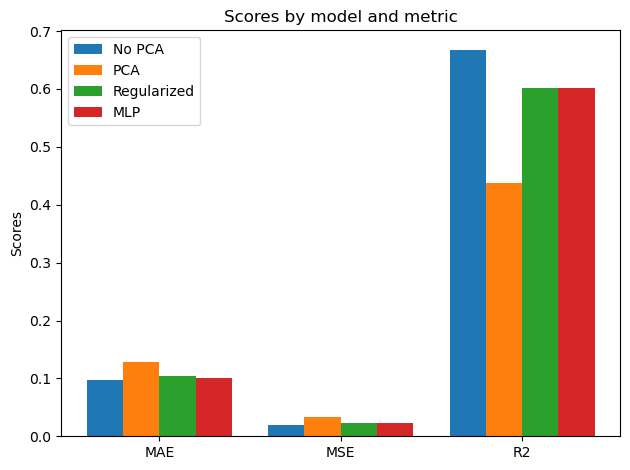

In [28]:

# Linear Regression without PCA
lr = LinearRegression()
lr.fit(full_train_data, full_train_target)

# Linear Regression with PCA
# best n_components is 3 by part 2
pca_lr = make_pipeline(PCA(n_components=3), LinearRegression())
pca_lr.fit(full_train_data, full_train_target)
# Apply the best regularized model to the test set
reg_pred = grid_en.predict(test_data)

# Apply the best MLP model to the test set
mlp_pred = best_model.predict(test_data)

# Define a function to calculate metrics to avoid repetition
def calculate_metrics(y_true, y_pred):
    return [mean_absolute_error(y_true, y_pred), 
            mean_squared_error(y_true, y_pred), 
            r2_score(y_true, y_pred)]

# Metrics for all models
metrics_lr = calculate_metrics(test_target, lr.predict(test_data))
metrics_pca_lr = calculate_metrics(test_target, pca_lr.predict(test_data))
metrics_reg = calculate_metrics(test_target, reg_pred)
metrics_mlp = calculate_metrics(test_target, mlp_pred)

labels = ["MAE", "MSE", "R2"]
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/2, metrics_lr, width, label='No PCA')
rects2 = ax.bar(x - width/2, metrics_pca_lr, width, label='PCA')
rects3 = ax.bar(x + width/2, metrics_reg, width, label='Regularized')
rects4 = ax.bar(x + 3*width/2, metrics_mlp, width, label='MLP')

ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


